## Supervised machine learning: Support Vector Machines

Having explored some unsupervised machine learning methods earlier, we will move on to supervised techniques. Supervised learning is the task of finding a mapping from input data to output labels based on example input-output pairs. During the training (or fitting) phase, the model builds an internal function which maps input to output, ideally in a way that can be generalized to yet-unseen data successfully. Once a model is trained, it can be used to predict output labels from new input data alone.

They come in two main groups: classifiers for categorical output labels, and regressors for continuous numeric output. We will only deal with classifiers in the little remaining time we have.

Our first dataset, like yesterday, will be the mouse gene expression data on the input side, and the diet labels on the output (also called "target") side. The first supervised model that we will train and evaluate is a support vector classifier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold

We load the expression and diet label data similarly to yesterday, including transposing the expression table so that samples (strain-diet combinations) correspond to rows, and their features (genes) correspond to columns. From now on we will use `0/1` encoding for CD/HFD for compatibility with a larger range of models. We will call the input DataFrame `data` and the Series with the desired outputs (diet labels) `target`.

In [2]:
def split_cd_hfd(input_df):
    input_df.index.name = 'gene'  # change that weird @format=column Excel index label to something meaningful
    input_cd = input_df.filter(regex=r'_CD|CD_') # loc[:, (input_df.columns.str.contains('CD_')) | (input_df.columns.str.contains('_CD'))]
    input_hfd = input_df.filter(regex=r'_HFD|HFD_') #loc[:, (input_df.columns.str.contains('HFD_')) | (input_df.columns.str.contains('_HFD'))]

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'strain'  # added only later
    
    return df_both.reset_index().set_index(['gene', 'diet']).sort_index()

In [3]:
xls = pd.read_excel('../example_data/aad0189_DataFileS5.xlsx', header=2)
expr = xls.groupby('Gene.1').mean().filter(regex='Liver')  # or 'Gene' if you had used that for your DE calculations
expr.columns = expr.columns.str.replace('_Liver', '')

In [4]:
data = split_cd_hfd(expr).unstack().T  # input data as one row per sample
target = data.index.to_frame()['diet'].replace({'CD': 0, 'HFD': 1}).rename('target')

## Task 1: Create a support vector classifier (SVC) using a linear kernel

### 1.1: Train it with the whole dataset
Use a simple linear kernel for the SVC and name the classifier object as `svc`.
Almost all classifiers in scikit-learn implement the following methods:

* `fit(data, target)` for training the model. This method changes the model's parameters and has a lasting effect.
* `predict(data)` for predicting outputs for `data` on an already trained model.
* `fit_predict(data, target)` combinines the two above. (What is wrong with it, and what legitimate purpose could it still serve?)
* `score(data, target)` predicts outputs for `data` and immediately compares the predicted output with `target`, returning the accuracy.

First, simply train the model with the entire dataset.

In [5]:
# fit svc model
svc = SVC(kernel='linear')
svc.fit(data, target)

SVC(kernel='linear')

### 1.2: Evaluate its accuracy on the training data

As discussed in the lecture, evaluating a machine learning model on the exact same data that you had trained it with won't tell you about the model's real accuracy, but it does tell you whether it is able to learn at all (in the worst case, mere memorization).

So, what is the model's accuracy on the training data, and consequently, what is the training error?

In [6]:
# calculate accuracy
print('ACCURACY:', svc.score(data, target))
print('ERROR:', 1-svc.score(data, target))

ACCURACY: 1.0
ERROR: 0.0


### 1.3: Compare the separating hyperplane's direction with the 4 direction vectors from yesterday's PCA

One advantage of linear SVM's is that the separating hyperplane is somewhat analogous to the direction vectors of the PCA algorithm. The hyperplane's direction (defined by its normal vector) tells us the weighted contribution of each feature in the classifier's decision.

To save you the trouble of moving code between sheets, we provide the PCA code below, and have put the principal direction vectors in `directions_df`. Add the separating hyperplane as a new column `linear_hyperplane`, and find a way to compare it with the principal direction vectors. Discuss what you found.

Hint: The separating hyperplane's direction (feature weights) are an attribute of a trained linear SVM object. [Find out where and how it is stored.](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

You can compare this direction with the PCA's direction vectors by calculating their correlation. What do you find?

In [7]:
# fit pca model
pca = PCA(n_components=4)
pca.fit(data)

directions_df = pd.DataFrame(pca.components_.T, index=data.columns, columns=['pd1', 'pd2', 'pd3', 'pd4'])  # each principal direction is a column vector now

directions_df['linear_hyperplane'] = svc.coef_[0]

directions_df.corr()

,pd1,pd2,pd3,pd4,linear_hyperplane
pd1,1.000000,-0.005243,0.002611,0.000787,0.613760
pd2,-0.005243,1.000000,0.015440,0.004657,-0.481925
pd3,0.002611,0.015440,1.000000,-0.002319,-0.335037
pd4,0.000787,0.004657,-0.002319,1.000000,0.080183
linear_hyperplane,0.613760,-0.481925,-0.335037,0.080183,1.000000


In [8]:
pca.singular_values_

array([109.6391427 ,  88.69803886,  73.4396326 ,  58.59133175])

### 1.4: Validate the model in a legitimate way
In 1.2 we asked you to evaluate the model with the same data you had trained it with. It's a poor (and borderline criminal) way to test a model's accuracy, since you can't tell whether the model has just memorized the exact inputs and expected outputs, or whether it truly found generalizable patterns in the data. The former scenario is called *overfitting*.

This time, train the model with one half of the data, and validate its accuracy on the other half. It will ensure that the test data will be new for the classifier, and it can't simply recall their output labels.

Keep it simple for now, first half of the rows for training and second half for validating should be good enough.

In [9]:
svc.fit(data[:len(data)//2], target[:len(data)//2])
print('ACCURACY:', svc.score(data[len(data)//2:], target[len(data)//2:]))

ACCURACY: 1.0


### 1.5: Reduce the number of features
You may have found that the model still performs perfectly, and it was successful at learning the structure of the data instead of just memorizing the training data. This a good sign, and it shows that it's not challenging for an SVM to distinguish the two diets from the full expression dataset. Let's make the SVM sweat a bit.

Try cutting down the number of used features up to the point that validation is no longer fully accurate, and the model starts making mistakes. You can use a DataFrame's `.sample(...)` method to select a given number of random rows (that's not what we want) or columns (`axis=1`). Store the reduced data in `data2 = data.sample(...)`.

You can simply re-run the same jupyter cell with decreasing sampling: we don't expect a graph or exhaustive measurements here, just find one small enough value that the accuracy isn't perfect anymore.

In [10]:
# reduce the number of feature and calculate accuracy
data2 = data.sample(n=20, axis=1)
svc.fit(data2[:len(data2)//2], target[:len(data2)//2])
print('ACCURACY:', svc.score(data2[len(data2)//2:], target[len(data2)//2:]))

ACCURACY: 0.8205128205128205


### 1.6: Perform cross-validation
Previously you had separated your data into a disjoint training and testing set, trained the model with the training set and computed its accuracy on the testing set. But you could also switch them around (train with the second half and test on the first half) and compute a second accuracy value. The average of those two values would give you an even better estimate of the real accuracy. This would be called a *2-fold cross-validation*.

3-fold cross-validation is when you split your data to D1/D2/D3 thirds, train the model with D1+D2 and test on D3. Then train with D1+D3 and test on D2, finally train with D2+D3 and test on D1. The average of the three accuracy values would be your model's 3-fold cross-validated accuracy.

(Sidenote: the *model* is the SVM with whatever parameters it has (linear + defaults) and the features that you use. During cross-validation you test different *instances* of the same model: you train them with different data so they will all end up slightly different, you test them with different data so the accuracy estimates will also be different, but you are validating the same *model* all along.)

`sklearn` gives you helper classes to split your data into training and testing sets following a cross-validation scheme, saving you most of the legwork. Some classes even support features like random shuffling, stratification (keeping labels balanced across training/testing classes) or repeated cross-validation, passing over the dataset multiple times with different random train/test folds.

### 1.6.1: Use KFold cross-validation with k=3

All cross-validator objects have a `.split(data)` method which creates an iterator that returns two elements in each iteration. The first element is the numeric indices of the rows that should be used for training, and the second element is the numeric indices of the rows to be used for testing.

You can slice your `data` and `target` into `data_train` and `target_train` with `.iloc[train_idx]`, and obviously also into `data_test` and `target_test` with `.iloc[test_idx]`.

In each fold, calculate the accuracy of the test folds, collect their results and finally calculate their average.

In [11]:
# fit kfold model with 3 and calculate accuracy
kf = KFold(n_splits=3)

acc = []

for train_idx, test_idx in kf.split(data2):

    data_train = data2.iloc[train_idx]
    target_train = target.iloc[train_idx]
    
    data_test = data2.iloc[test_idx]
    target_test = target.iloc[test_idx]
    
    svc_cv = SVC(kernel = "linear").fit(data_train, target_train)
    acc.append(svc_cv.score(data_test,target_test))

print("ACCURACY: ", np.mean(acc))

ACCURACY:  0.8461538461538461


### 1.6.2: Use a fancy cross-validator of your choice
Your cross-validation results depended on the data's original ordering, since KFold just slices your data into contiguous blocks. It your data had been ordered differently (for example, all CD samples at the beginning, all HFD at the end) the KFold method would have ended up with massively imbalanced labels in different folds.

To prevent this, there are cross-validators that either shuffle the data before cutting it into folds, or actively monitor the labels and ensure that the folds are balanced in their target label composition. Try out some of these.

In [12]:
# kfold is not enough, so use repeat kfold function to verify accuracy
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)

acc = []

for train_idx, test_idx in rskf.split(data2,target):
    data_train = data2.iloc[train_idx]
    target_train = target.iloc[train_idx]
    
    data_test = data2.iloc[test_idx]
    target_test = target.iloc[test_idx]
    
    svc_cv = SVC(kernel = "linear").fit(data_train, target_train)
    acc.append(svc_cv.score(data_test,target_test))

print("ACCURACT: ", np.mean(acc))

ACCURACT:  0.8525641025641025


### 1.6.3: Use the convenience function `cross_val_score`

Scikit-learn provides a handful of convenience functions so that you don't have to write for-loops to train, test and aggregate results. The function `cross_val_score` takes a machine learning model, your data, the target labels, and a cross-validator object, and returns the fold accuracies in a numpy array.

If you also want to obtain the predicted labels (instead of just the accuracies) that each test fold produced, it can also aggregate those for you with another convenience function called `cross_val_predict`. This is especially useful if you are interested in the particular samples where the model's predictions failed. It also allows you to evaluate more fine-grained performance metrics of the model, such as sensitivity, specificity, etc. But it's enough to use `cross_val_score` now.

In [13]:
cross_val_score(svc,data2,target)

array([0.8125, 0.75  , 0.875 , 1.    , 0.8   ])

In [14]:
cross_val_predict(svc,data2,target)

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

### 1.7: Add noise to test the SVM's robustness

Using the small `data2` dataset (with <50 features) add increasing amounts of random noise to the data. Numpy's `np.random.randn(*data2.shape)` will generate a matrix with normally distributed random values, which you can multiply with a scaling factor, and add to `data2`.

Plot the model's accuracy against the noise level. You can use a `RepeatedKFold` or `RepeatedStratifiedKFold` cross-validator object to get more precise accuracy values in each step, making your graph a bit smoother.

Text(0, 0.5, 'accuracy')

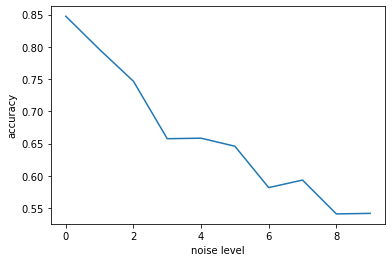

In [15]:
noise = np.random.randn(*data2.shape)
noise_levels = np.linspace(0,1,10)
acc = []
for i in noise_levels:
    test_data = data2+i*noise
    acc.append(cross_val_score(svc,test_data,target).mean())
plt.plot(acc)
plt.xlabel('noise level')
plt.ylabel('accuracy')

ACCURACT:  0.8846153846153846
ACCURACT:  0.842948717948718
ACCURACT:  0.814102564102564
ACCURACT:  0.7836538461538461
ACCURACT:  0.7628205128205128
ACCURACT:  0.7489316239316239
ACCURACT:  0.7380952380952382
ACCURACT:  0.71875
ACCURACT:  0.6930199430199431
ACCURACT:  0.6775641025641026


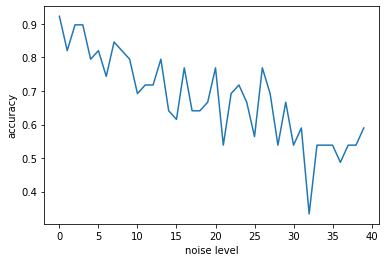

In [16]:
noise = np.random.randn(*data2.shape)
noise_levels = np.linspace(0,1,10)
acc = []
for i in noise_levels:
    test_data = data2+i*noise
    for train_idx, test_idx in rskf.split(test_data,target):
        data_train = test_data.iloc[train_idx]
        target_train = target.iloc[train_idx]

        data_test = test_data.iloc[test_idx]
        target_test = target.iloc[test_idx]

        svc_cv = SVC(kernel = "linear").fit(data_train, target_train)
        acc.append(svc_cv.score(data_test,target_test))

    print("ACCURACT: ", np.mean(acc))
plt.plot(acc)
plt.xlabel('noise level')
plt.ylabel('accuracy')
plt.show()

### 1.8: Optional: Create a training error / testing error graph as a function of noise

For this, you will have to revert to using `for` loops because `cross_val_score` does not return the training accuracy values, so you have to obtain them manually.

Text(0, 0.5, 'accuracy')

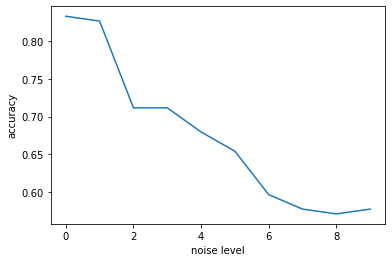

In [17]:
noise = np.random.randn(*data2.shape)
noise_levels = np.linspace(0,1,10)
acc_test = []
acc_train = []
for i in noise_levels:
    test = []
    train = []
    test_data = data2+i*noise
    for train_idx, test_idx in rskf.split(test_data,target):
        data_train = test_data.iloc[train_idx]
        target_train = target.iloc[train_idx]

        data_test = test_data.iloc[test_idx]
        target_test = target.iloc[test_idx]

        svc_cv = SVC(kernel = "linear").fit(data_train, target_train)
        train.append(svc_cv.score(data_test,target_test))
        test.append(svc_cv.score(data_test,target_test))
    
    acc_train.append(np.mean(train))
    acc_test.append(np.mean(test))
plt.plot(acc_test)
plt.xlabel('noise level')
plt.ylabel('accuracy')